# Volume 3: Metropolis
    Spencer Halverson
    MATH 405
    2022-01-25

In [2]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from math import sqrt, exp, log
import seaborn as sbn

## Problem 1

Write a function that uses the Metropolis hastings algorithm to draw from the posterior distribution over the mean $\mu$ and variance $\sigma ^2$. Use the given functions and algorithm 1.1 to complete the problem.

Your function should return an array of draws, an array of the log probabilities, and an acceptance rate. 
Using the seaborn.kdeplot function, plot the first 500 log probabilitis, the $\mu$ samples and posterior distribution, and the $\sigma ^2$ samples and posterior distribution. 

(Hint: When checking your acceptance, remember you are in log space.)

Compare your results with Fig 1.1 and 1.2

In [5]:
# load data
scores = np.load("examscores.npy")

# initialize constants and priors
alpha = 3
beta = 50
m = 80
s = 4

muprior = stats.norm(loc=m, scale=np.sqrt(s**2))
sig2prior = stats.invgamma(alpha, scale=beta)

In [6]:
def proposal(x,s):
    """The proposal function Q(x,y) = N(x|y,sI)."""
    return stats.multivariate_normal.rvs(mean=x, cov=s*np.eye(len(x)))

In [29]:
def propLogDensity(x):
    """Calculate the log of the proportional density."""
    logprob = muprior.logpdf(x[0]) + sig2prior.logpdf(x[1])
    logprob += stats.norm.logpdf(scores, loc=x[0], scale=np.sqrt(x[1])).sum()
    return logprob    # ^this is where the scores are used.

In [10]:
def acceptance(x, y):
    return min(0, propLogDensity(x) - propLogDensity(y))

In [42]:
def metropolis(y0, s, n_samples):
    """Use the Metropolis algorithm to sample from posterior.
    Parameters:
     y0 ((2,) ndarray): The first entry is mu, the second entry is sigma^2.
     s (float): The standard deviation parameter for the proposal function.
     n_samples (int): The number of samples to generate.
   
   Returns:
     draws ((n_samples, 2) ndarray): The MCMC samples.
     logprobs ((n_samples,) ndarray): The log density of the samples.
     accept_rate (float): The proportion of accepted proposed samples."""
    # initialize tracking variables
    y = np.empty((n_samples+1, y0.shape[0])) # draws
    y[0] = y0
    accept_rate = 0
    log_probs = np.empty(n_samples+1)
    log_probs[0] = 1. # the first entry will be discarded at the end

    for t in range(1, n_samples+1):
        x = proposal(y[t-1], s)
        a = np.random.random() # draw a uniformly
        accept = acceptance(x, y[t-1])
        log_probs[t] = accept
        if np.log(a) <= accept:
            y[t] = x
            accept_rate += 1
        else:
            y[t] = y[t-1]
        # print(y[t])
    accept_rate /= n_samples
    return y[1:], log_probs[1:], accept_rate

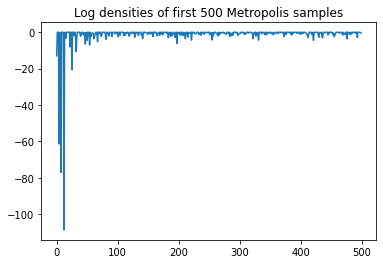

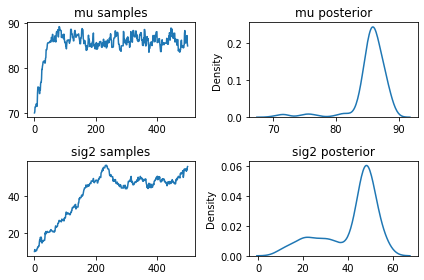

Acceptance rate: 0.698



In [133]:
y0 = np.array([70, 10])
# print(scores)
draws, log_probs, accept_rate = metropolis(y0, s=1, n_samples=500)

# plot
plt.title("Log densities of first 500 Metropolis samples")
plt.plot(log_probs)
plt.show()

fig, ax = plt.subplots(2,2)

ax[0, 0].plot(draws[:,0])
ax[0,0].set_title("mu samples")
sbn.kdeplot(draws[:,0], ax=ax[0,1])
ax[0,1].set_title("mu posterior")

ax[1, 0].plot(draws[:,1])
ax[1,0].set_title("sig2 samples")
sbn.kdeplot(draws[:,1], ax=ax[1,1])
ax[1,1].set_title("sig2 posterior")


plt.tight_layout()
plt.show()

print("Acceptance rate:", accept_rate)
print("")

## Problem 2

Write a function that accepts a spin configuration $\sigma$ for a lattice as a NumPy array.
Compute the energy $H(\sigma)$ of the spin configuration.
Be careful to not double count site pair interactions!

In [60]:
def random_lattice(n):
    """Construct a random spin configuration for an nxn lattice."""
    random_spin = np.zeros((n,n))
    for k in range(n):
        random_spin[k,:] = 2*np.random.binomial(1,.5, n) -1
    return random_spin

In [72]:
def lattice_energy(L):
    """Computer the energy of the spin configuration corresponding to the
    lattice L.
    Parameter:
     L (ndarray): A lattice that we want the spin configuration for.
    
    Returns:
     (float): The spinfiguration of the lattice.
    """
    # create a Lattice that loops on itself
    m,n = L.shape
    pad_L = np.empty((m+1, n+1))
    pad_L[:m, :n] = L
    pad_L[-1, :n] = L[0, :]
    pad_L[:m, -1] = L[:, 0]
    pad_L[-1, -1] = 0.

    # check energy of ones to the right and below (so we don't double-count)
    H = 0
    H += np.sum(pad_L[:m, :n]*pad_L[1:, :n])
    H += np.sum(pad_L[:m, :n]*pad_L[:m, 1:])

    return H

## Problem 3

Write a function that accepts an integer $n$ and chooses a pair of indices $(i,j)$ where $0 \le i,j \le n-1$.
Each possible pair should have an equal probability $\frac{1}{n^2}$ of being chosen.

In [77]:
def flip_location(n):
    """Choose a random pair of indices 0 <= i,j <= n-1.
    Parameter:
     n (int): 1/(n^2) probability for each location
     
    Returns:
     (index1, index2) (tuple): the tuple pair of the chosen indices. 
    """
    i = np.random.randint(0, n)
    j = np.random.randint(0, n)
    return i,j   

## Problem 4

Write a function that accepts a spin configuration $\sigma$, its energy $H(\sigma)$, and integer indices $i$ and $j$.
Compute the energy of the new spin configuration $\sigma^*$, which is $\sigma$ but with the spin flipped at the $(i,j)$th entry of the corresponding lattice.
Do not explicitly construct the new lattice for $\sigma^*$.

In [119]:
def updated_energy(L, L_energy, i, j):
    """Compute the energy of the spin configuration that results
    when the (i,j)th spin of L is flipped.
    
    Parameters:
     L (ndarray): the spin configuration 
     L_energy (float): the energy of the spin configuration.
     i (int): the first index.
     j (int): the second index.
    Returns:
     (float): the energy of the new updated lattice
    """
    m,n = L.shape
    current = L[i,j] # get current value
    new = current * -1 # flip current value

    ## compute new energy H
    H = L_energy
    # top
    H -= 2*new*L[i-1, j]

    # bottom
    H -= 2*new*L[(i+1)%m, j]

    # left
    H -= 2*new*L[i, j-1]

    # right
    H -= 2*new*L[i, (j+1)%n]

    return H

## Problem 5

Write a function that accepts a float $\beta$ and spin configuration energies $H(\sigma)$ and $H(\sigma^*)$.
Calculate whether or not the new spin configuration $\sigma^*$ should be accepted (return `True` or `False`).

(Hint: np.random.binomial() might be useful function)

In [120]:
def accept(beta, energy_old, energy_new):
    """Accept or reject the new spin configuration.
    
    Parameters:
     beta (float): a quantity inversly proportional to the temperature.
     energy_old (float): the energy of the old lattice.
     energy_new (float): the energy of the updated lattice.
     
    Returns:
     (boolean): whether the new energy should be accepted or not
    """
    A = min(0, beta*(energy_old-energy_new)) # log probability
    a = np.random.random()
    if np.log(a) <= A:
        return True
    else:
        return False

## Problem 6

Write a function that accepts a float $\beta>0$ and integers $n$, `n_samples`, and `burn_in`.
Initialize an $n\times n$ lattice for a spin configuration $\sigma$ using `random_lattice()`.
Use the Metropolis algorithm to (potentially) update the lattice `burn_in` times.
1. Use `flip_location()` to choose a site for possibly flipping the spin, thus defining a potential new configuration $\sigma^*$.
2. Use `updated_energy()` to calculate the energy $H(\sigma^*)$ of the proposed configuration.
3. Use `accept()` to accept or reject the proposed configuration. If it is accepted, set $\sigma = \sigma^*$ by flipping the spin at the indicated site.
4. Track $-\beta H(\sigma)$ at each iteration (independent of acceptance).

After the burn-in period, continue the iteration `n_samples` times, also recording every $100$th sample (to prevent memory failure).
Return the samples, the sequence of weighted energies $-\beta H(\sigma)$, and the acceptance rate.

Test your sampler on a $100 \times 100$ grid with $200000$ total iterations, with `n_samples` large enough so that you will keep $50$ samples, for $\beta = 0.2, 0.4, 1$.
Plot the proportional log probabilities, as well as a late sample from each test.


In [124]:
def ising_metropolis(beta, n=100, n_samples=5000, burn_in=195000):
    """Use the Metropolis algorithm to choose new spin configurations.

    Parameters:
        beta (float > 0): Constant inversely proportional to the temperature.
        N (int > 0): The size of the lattice.
        n_samples (int): The number of samples to generate.
        burnin (int): The number of iterations to burn before sampling.

    Returns:
        ((n_samples//100, n,n) ndarray): The sampled spin configurations.
        (n_samples) ndarray: The weighted energies of each configuration.
        (float): The proportion of proposed samples that were accepted.
    """
    # storage arrays
    beta_energy = np.empty(n_samples+burn_in)
    samples = np.empty((n_samples//100, n, n))
    accept_rate = 0

    # initial lattice
    L = random_lattice(n)
    L_energy = lattice_energy(L)

    for t in range(burn_in):
        # find proposal flip
        i,j = flip_location(n) 

        # compute energy of new configuration
        energy_new = updated_energy(L, L_energy, i,j) 

        if accept(beta, L_energy, energy_new):
            L[i,j] *= -1
            L_energy = energy_new

        beta_energy[t] = -beta*L_energy
    
    for t in range(n_samples):

        # find proposal flip
        i,j = flip_location(n) 

        # compute energy of new configuration
        energy_new = updated_energy(L, L_energy, i,j) 

        if accept(beta, L_energy, energy_new):
            L[i,j] *= -1
            L_energy = energy_new
            accept_rate += 1

        beta_energy[t+burn_in] = -beta*L_energy

        if (t+1)%100 == 0:
            samples[((t+1)//100)-1, :, :] = L
    
    accept_rate /= n_samples
        
    return samples, beta_energy, accept_rate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


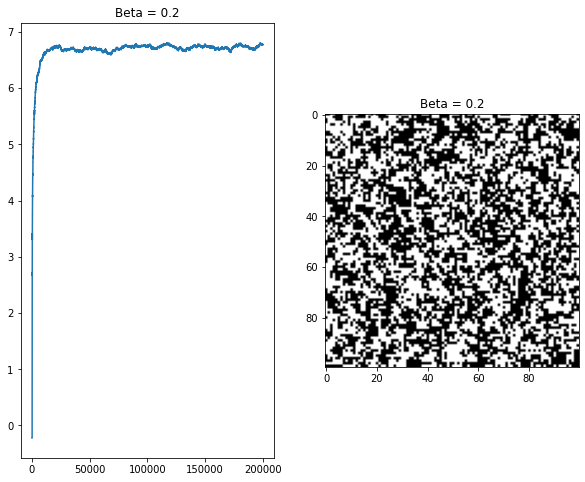

Acceptance rate: 0.6894



In [130]:
beta = 0.2
samples, beta_energy, accept_rate = ising_metropolis(beta)

# Plot proportional log probability
fig, ax = plt.subplots(ncols=2, figsize=(10,8))
ax[0].plot(np.log(beta_energy))
ax[0].set_title("Beta = {}".format(beta))
ax[1].plot()
plt.imshow(samples[-1, :, :].squeeze(), cmap='gray')
plt.title("Beta = {}".format(beta))
plt.show()

print("Acceptance rate:", accept_rate)
print("")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


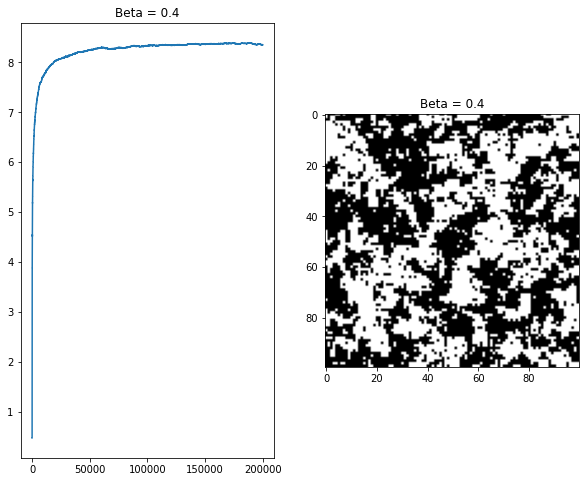

Acceptance rate: 0.328



In [131]:
beta = 0.4
samples, beta_energy, accept_rate = ising_metropolis(beta)

# Plot proportional log probability
fig, ax = plt.subplots(ncols=2, figsize=(10,8))
ax[0].plot(np.log(beta_energy))
ax[0].set_title("Beta = {}".format(beta))
ax[1].plot()
plt.imshow(samples[-1, :, :].squeeze(), cmap='gray')
plt.title("Beta = {}".format(beta))
plt.show()

print("Acceptance rate:", accept_rate)
print("")

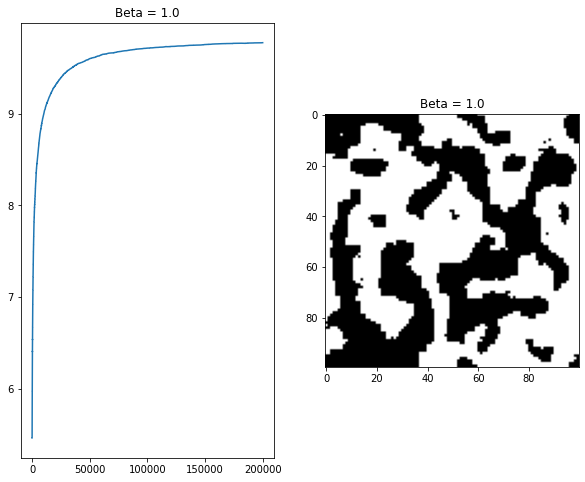

Acceptance rate: 0.069



In [132]:
beta = 1.0
samples, beta_energy, accept_rate = ising_metropolis(beta)

# Plot proportional log probability
fig, ax = plt.subplots(ncols=2, figsize=(10,8))
ax[0].plot(np.log(beta_energy))
ax[0].set_title("Beta = {}".format(beta))
ax[1].plot()
plt.imshow(samples[-1, :, :].squeeze(), cmap='gray')
plt.title("Beta = {}".format(beta))
plt.show()

print("Acceptance rate:", accept_rate)
print("")

As temperature lowers, spin configurations stick together, with more structure and less noise.